# Cleaning and Data Integration

This notebook is reading 10k_synthea_covid19_csv to analyze those that are similar to the Enclave files:
    
    Enclave Files:
    
    Demographics: Person
    Conditions: Condition
    Observations: Observations
    Diagnosis: Dem, Cond, Obse
    Drugs
    
    Synthea Files:
    
    Conditions: Conditions
    Observations: Observations
    Medications: Drugs
    Patients: Demographics
    Diagnosis: Patients, Cond, Obse
    




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer,StandardScaler
from pyspark.ml import Pipeline

from pyspark.sql.functions import col, when, sum, first,  countDistinct, max
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.stat import Statistics 
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql import Window
import pyspark.sql.functions as f

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_patients = pd.read_csv('../data/patients.csv')
df_conditions = pd.read_csv('../data/conditions.csv')
df_observations = pd.read_csv('../data/observations.csv')
df_medications = pd.read_csv('../data/medications.csv')

### Demographics - Patients

Enclave Demographics Columns

person_id,
pasc_code_after_four_weeks,

age,
ageGroup_infant,
ageGroup_toddler,
ageGroup_adolescent,
ageGroup_youngAd,
ageGroup_adult,
ageGroup_olderAd,
ageGroup_elderly,

gender_fem,
gender_mal,
gender_unk,

race_none,
race_mult,
race_unk,
race_whi,
race_his,
race_asi,
race_bla,
race_nat,
race_ind,

ethnicity_unk,
ethnicity_his,
ethnicity_notHis,

In [4]:
cols = ['Id', 'BIRTHDATE', 'RACE','ETHNICITY','GENDER']
df = df_patients[cols]

In [5]:
df['BIRTHDATE']=df['BIRTHDATE'].astype(str).str[0:4].astype(int)
df['age'] = 2021 - df['BIRTHDATE']

In [6]:
df

,Id,BIRTHDATE,RACE,ETHNICITY,GENDER,age
0,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,2017,white,nonhispanic,M,4
1,067318a4-db8f-447f-8b6e-f2f61e9baaa5,2016,white,nonhispanic,F,5
2,ae9efba3-ddc4-43f9-a781-f72019388548,1992,white,nonhispanic,M,29
3,199c586f-af16-4091-9998-ee4cfc02ee7a,2004,white,nonhispanic,F,17
4,353016ea-a0ff-4154-85bb-1cf8b6cedf20,1996,white,nonhispanic,M,25
...,...,...,...,...,...,...
12347,eec72396-d10e-4b8e-8fb6-25fc1e396031,1962,asian,nonhispanic,F,59
12348,3daf2b90-c439-469f-bb44-fb6109c6a8a7,1918,white,nonhispanic,F,103
12349,cb03d88e-7f08-46a1-be78-70d9fe8262a7,1918,white,nonhispanic,F,103
12350,435be43f-cb57-442f-aeb2-51018b030ed0,1918,white,nonhispanic,F,103


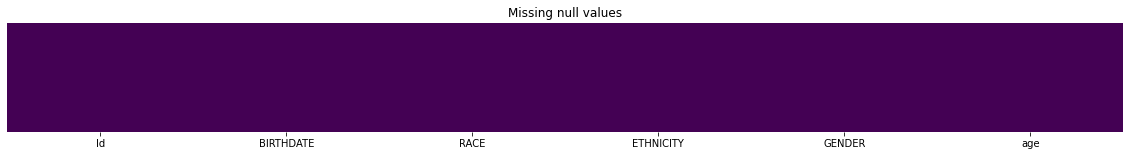

In [7]:
plt.rcParams['figure.figsize'] = (20,2)
sns.heatmap(df.isna(), yticklabels = False, cbar = False , cmap = 'viridis')
plt.title("Missing null values")
plt.show()

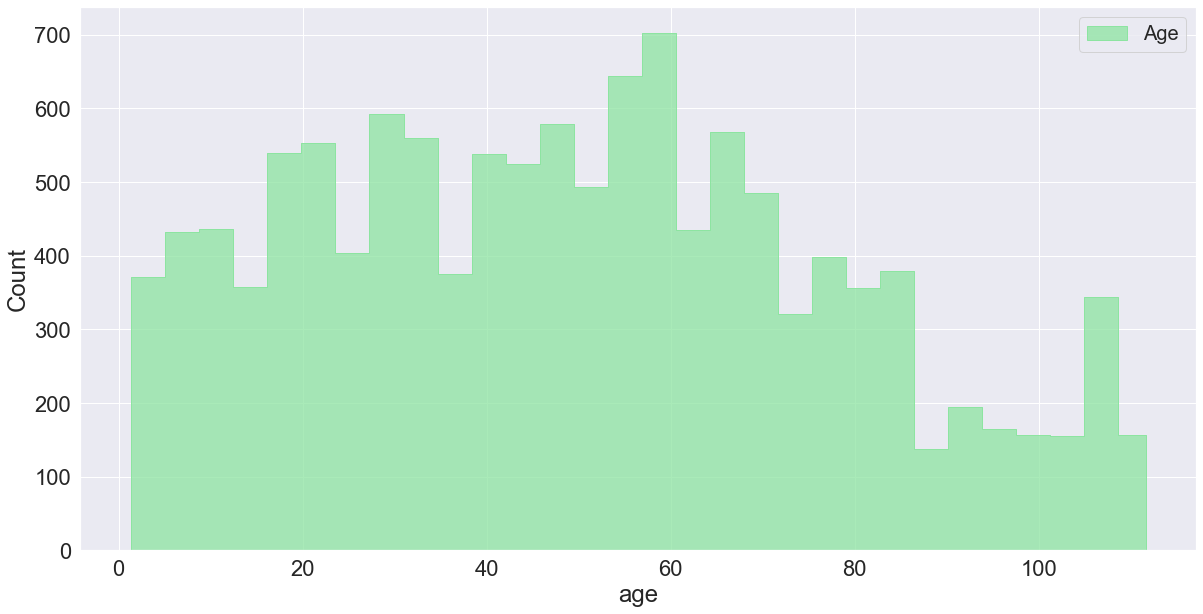

In [8]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set(font_scale=2)

g = sns.histplot(data=df, x='age', shrink=0.8, color='#8de4a1', label='Age', element="step", stat="count")

plt.legend(loc='upper right', fontsize=20)
plt.show()

### Age

In [9]:
df['ageGroup_infant'] = 1
df['ageGroup_toddler'] = 1
df['ageGroup_adolescent'] = 1
df['ageGroup_youngAd'] = 1
df['ageGroup_adult'] = 1
df['ageGroup_olderAd'] = 1
df['ageGroup_elderly'] = 1


df.loc[df['age'] > 2, 'ageGroup_infant'] = 0
df.loc[(df['age'] <= 2) & (df['age'] < 4), 'ageGroup_toddler'] = 0
df.loc[(df['age'] <= 4) & (df['age'] < 14), 'ageGroup_adolescent'] = 0
df.loc[(df['age'] <= 14) & (df['age'] < 30), 'ageGroup_youngAd'] = 0
df.loc[(df['age'] <= 30) & (df['age'] < 50), 'ageGroup_adult'] = 0
df.loc[(df['age'] <= 50) & (df['age'] < 90), 'ageGroup_olderAd'] = 0
df.loc[df['age'] <= 90, 'ageGroup_elderly'] = 0

### Gender, Race, Ethnicity

In [10]:
print(df['RACE'].unique())
print(df['GENDER'].unique())
print(df['ETHNICITY'].unique())

['white' 'native' 'asian' 'black' 'other']
['M' 'F']
['nonhispanic' 'hispanic']


In [11]:
df['race_white'] = 1
df['race_native'] = 1
df['race_asian'] = 1
df['race_black'] = 1
df['race_other'] = 1
df['gender_M'] = 1
df['gender_F'] = 1
df['ethnicity_non'] = 1
df['ethnicity_his'] = 1


df.loc[df['RACE'] == 'white', 'race_white'] = 0
df.loc[(df['RACE'] == 'native') , 'race_native'] = 0
df.loc[(df['RACE'] == 'asian') , 'race_asian'] = 0
df.loc[(df['RACE'] == 'black') , 'race_black'] = 0
df.loc[(df['RACE'] == 'other') , 'race_other'] = 0
df.loc[(df['GENDER'] == 'M') , 'gender_M'] = 0
df.loc[df['GENDER'] == 'F', 'gender_F'] = 0
df.loc[(df['ETHNICITY'] == 'nonhispanic') , 'ethnicity_non'] = 0
df.loc[df['ETHNICITY'] == 'hispanic', 'ethnicity_his'] = 0
df =df.drop(['BIRTHDATE', 'RACE', 'ETHNICITY', 'GENDER', 'age'], axis =1)


In [12]:
df['Id']=df['Id'].astype(str)
df.rename(columns = {'Id':'PATIENT'}, inplace = True)
df_patients = df
df_patients.to_excel("output/Patients_Demographics_Synthea.xlsx") 

### Conditions

    Formatting data types and calculating condition duration (STOP-START). 
    DURATION : how long that a single occurence of a condition lasted
    TOTAL_DURATION_CON : sum of all durations
    CON_PER_ENCOUNTER : count of condition CODE per encounter 
    ENCOUNTER_PER_CON : count of encounters per condition (visits)

In [13]:
df_conditions['PATIENT']=df_conditions['PATIENT'].astype(str)
df_conditions['START'] = pd.to_datetime(df_conditions['START'])
df_conditions['STOP']=pd.to_datetime(df_conditions['STOP'])
df_conditions['DESCRIPTION']=df_conditions['DESCRIPTION'].astype(str)
df_conditions['DURATION'] = df_conditions['STOP'] - df_conditions['START']
df_conditions['DURATION']= df_conditions['DURATION']/ np.timedelta64(1, 'D')
df_conditions['TOTAL_DURATION_CON'] = df_conditions.groupby(['PATIENT','CODE'], sort=False)['DURATION'].transform('sum')
df_conditions =df_conditions.drop(['START', 'STOP', 'DURATION'], axis=1)

In [14]:
df_conditions['CON_PER_ENCOUNTER'] = df_conditions.groupby(['PATIENT','ENCOUNTER'], sort=False)['CODE'].transform('count')
df_conditions['ENCOUNTER_PER_CON'] = df_conditions.groupby(['PATIENT','CODE'], sort=False)['ENCOUNTER'].transform('count')
df_conditions = df_conditions.drop(['ENCOUNTER'], axis=1)

In [15]:
df_conditions = df_conditions.drop_duplicates()
df_conditions.rename(columns = {'CODE':'CONDITION_CODE', 'DESCRIPTION':'CONDITION_DESC'}, inplace = True)
df_conditions.to_excel("output/Conditions_Synthea.xlsx") 

In [16]:
df_conditions
#multiple conditions per patient

,PATIENT,CONDITION_CODE,CONDITION_DESC,TOTAL_DURATION_CON,CON_PER_ENCOUNTER,ENCOUNTER_PER_CON
0,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,65363002,Otitis media,259.0,1,2
2,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,386661006,Fever (finding),29.0,3,1
3,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,840544004,Suspected COVID-19,0.0,3,1
4,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,840539006,COVID-19,29.0,3,1
5,067318a4-db8f-447f-8b6e-f2f61e9baaa5,44465007,Sprain of ankle,14.0,1,1
...,...,...,...,...,...,...
114539,2712205f-755e-4897-acb3-926895b7d635,248595008,Sputum finding (finding),28.0,6,1
114540,2712205f-755e-4897-acb3-926895b7d635,68962001,Muscle pain (finding),28.0,6,1
114541,2712205f-755e-4897-acb3-926895b7d635,57676002,Joint pain (finding),28.0,6,1
114542,2712205f-755e-4897-acb3-926895b7d635,840544004,Suspected COVID-19,0.0,6,1


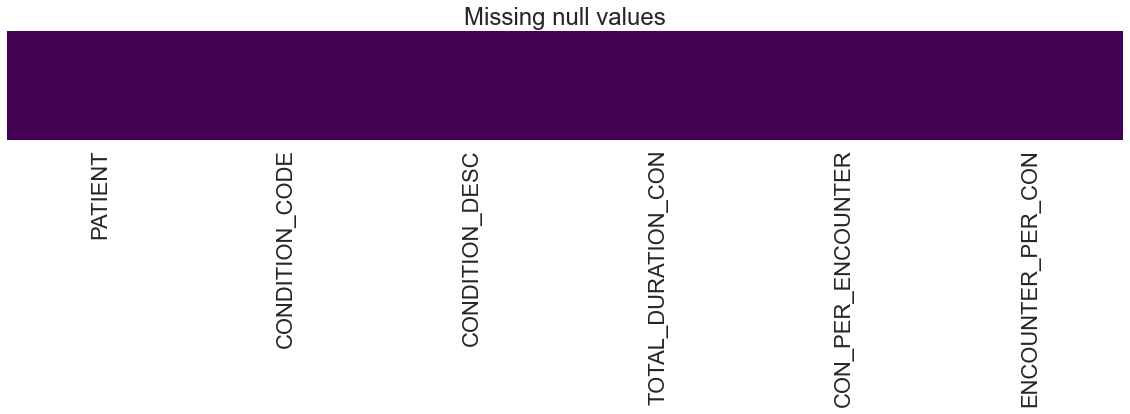

In [17]:
plt.rcParams['figure.figsize'] = (20,2)
sns.heatmap(df_conditions.isna(), yticklabels = False, cbar = False , cmap = 'viridis')
plt.title("Missing null values")
plt.show()


#### Covid code conditions 
 - Synthea COVID-19 Analysis.html
 - [Synthea Git](https://github.com/synthetichealth/synthea-sample-data/blob/master/downloads/10k_synthea_covid19_csv.zip)
 - file also in Synthea Pipeline/data/10k_synthea_covid19_csv 

In [18]:
df_covid = df_conditions.loc[(df_conditions['CONDITION_CODE']) == 840539006]
df_covid.to_excel("output/CovidPatients_Synthea.xlsx") 

### Observations

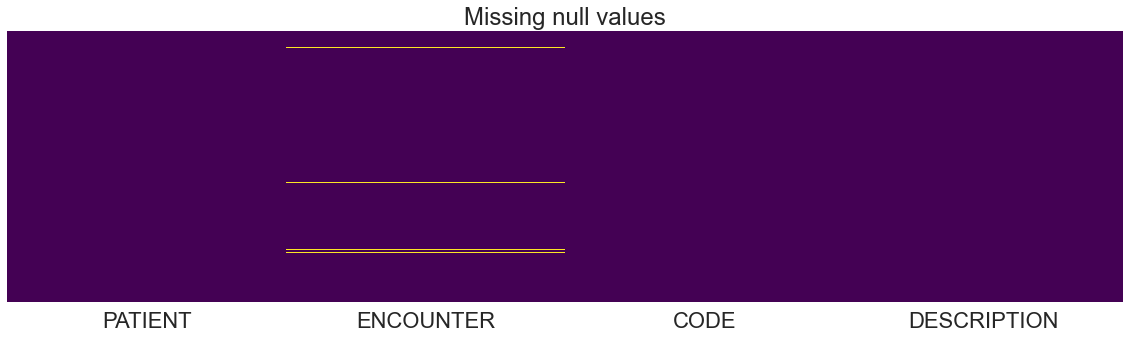

In [19]:
df_observations = df_observations.drop(['DATE', 'VALUE', 'UNITS', 'TYPE'], axis=1)
plt.rcParams['figure.figsize'] = (20,5)
sns.heatmap(df_observations.isna(), yticklabels = False, cbar = False , cmap = 'viridis')
plt.title("Missing null values")
plt.show()


In [20]:
df_observations.rename(columns = {'CODE':'OBSERVATION_CODE', 'DESCRIPTION':'OBSERVATION_DESC'}, inplace = True)
df_observations.to_csv("output/Observations_Synthea.csv") 

### Medications - Drugs

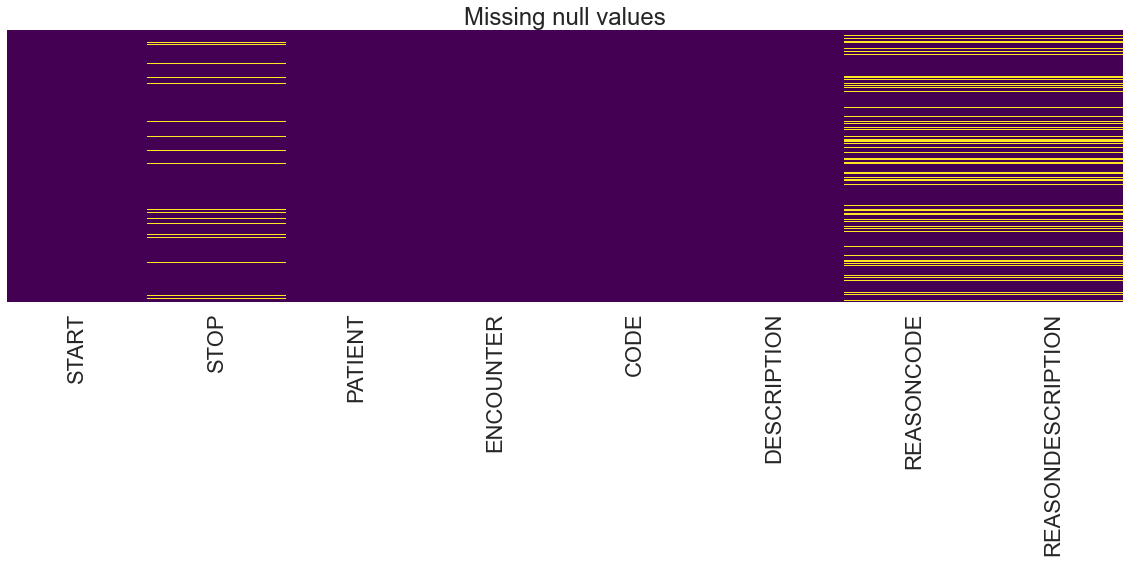

In [21]:
df_medications = df_medications.drop(['PAYER', 'BASE_COST', 'PAYER_COVERAGE', 'DISPENSES', 'TOTALCOST'], axis=1)
plt.rcParams['figure.figsize'] = (20,5)
sns.heatmap(df_medications.isna(), yticklabels = False, cbar = False , cmap = 'viridis')
plt.title("Missing null values")
plt.show()

In [22]:
df_medications['PATIENT']=df_medications['PATIENT'].astype(str)
df_medications['START'] = pd.to_datetime(df_medications['START'])
df_medications['STOP']=pd.to_datetime(df_medications['STOP'])
df_medications['DESCRIPTION']=df_medications['DESCRIPTION'].astype(str)
df_medications['DURATION'] = df_medications['STOP'] - df_medications['START']
df_medications['DURATION']= df_medications['DURATION']/ np.timedelta64(1, 'D')
df_medications['TOTAL_DURATION_MED'] = df_medications.groupby(['PATIENT','CODE'], sort=False)['DURATION'].transform('sum')
df_medications= df_medications.drop(['START', 'STOP', 'DURATION'], axis=1)

In [23]:
df_medications['OBS_PER_ENCOUNTER_MED'] = df_medications.groupby(['PATIENT','ENCOUNTER'], sort=False)['CODE'].transform('count')
#this encounter they went for only one code 'condition'
df_medications['ENCOUNTER_PER_MED'] = df_medications.groupby(['PATIENT','CODE'], sort=False)['ENCOUNTER'].transform('count')
df_medications = df_medications.drop(['ENCOUNTER'], axis=1)
df_medications.rename(columns = {'CODE':'MEDICATION_CODE', 'DESCRIPTION':'MEDICATION_DESC'}, inplace = True)
df_medications.to_csv("output/Medications_Drugs_Synthea.csv") 
